In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics import roc_auc_score
from scipy.signal import correlate

### Problem 1:  
### Convolutions

1.  Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4]and the kernal is [1,1] for stride =1 and padding =0.

2.  Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4]and the kernal is [1,-1] for stride =1 and padding =1 (padding one means on both sides)




3.  Write pytorch code that computes these outputs.  Create the corresponding tensors and usetorch.nn.Conv1d and ConvTranspose1d.

In [2]:


'''
Part 1
'''
x1 = [1, -1, 3, 4, 4]
kernel1 = [1, 1]

output = correlate(x1, kernel1, mode="valid")
print("Part 1")
print(output)

print()

'''
Part 2
'''

x2 = [0, 1, -1, 3, 4, 4, 0]
kernel2 = [1, -1]

output = correlate(x2, kernel2, mode="valid")
print("Part 2")
print(output)
print()



'''
Part 3
'''

x_tensor = torch.tensor([[[1, -1, 3, 4, 4]]])
kernel1_tensor = torch.tensor([[[1, 1]]])
kernel2_tensor = torch.tensor([[[1, -1]]])

# Part 1 of part 3
conv1 = nn.Conv1d(in_channels=1, stride=1, kernel_size=2, padding=0, out_channels=1,  bias=False)
conv1.weight.data = kernel1_tensor
y1 = conv1(x_tensor)
print("Part 3")
print(f"Kernel={kernel1}, stride=1, Padding=0, Convolution={y1}")


# Part 2 of part 3
conv2 = nn.Conv1d(in_channels=1,stride=1,kernel_size=2, padding=1,out_channels=1, bias=False)
conv2.weight.data = kernel2_tensor
y2 = conv2(x_tensor)


print(f"Kernel={kernel2}, stride=1, Padding=1, Convolution={y2}")


Part 1
[0 2 7 8]

Part 2
[-1  2 -4 -1  0  4]

Part 3
Kernel=[1, 1], stride=1, Padding=0, Convolution=tensor([[[0, 2, 7, 8]]], grad_fn=<SqueezeBackward1>)
Kernel=[1, -1], stride=1, Padding=1, Convolution=tensor([[[-1,  2, -4, -1,  0,  4]]], grad_fn=<SqueezeBackward1>)



### Problem 2:  Training a CIFAR-10 CNN classifier.


In this problem we will follow a tutorial to build a Convolutional neural network that classifiesimages from the CIFAR-10 dataset and then modify it.

1.  Start by implementing and running this tutorial.https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/Show  the  accuracy  you  get  and  also  theconfusion matrix you obtain for the 10 classes.


2.  Show the convolutional layer kernels you learned in the first convolutional layer.

3.  Replace the architecture with AlexNet (https://github.com/icpm/pytorch-cifar10/blob/master/models/AlexNet.py)  and  report  accuracy.   Tune  hyperparameters  to  get  the  bestpossible accuracy on a test set.


4.  Using the first CNN you trained, build another binary classifer that classifies images as ’Plane’or ’Not Plane’.  Compute the AUC of this binary classifier.  Retrain this classifier to improvethe AUC for this binary classification task.  Report how you did that and what is the bestAUC you were able to obtain.

In [3]:
'''
Part 1
'''
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((.5, .5, .5), (.5, .5, .5))])


trainset = torchvision.datasets.CIFAR10(root='./home/CIFAR-10 Classifier Using CNN in PyTorch/data/',
                                       train=True,
                                       download=True,
                                       transform=transform,)


trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


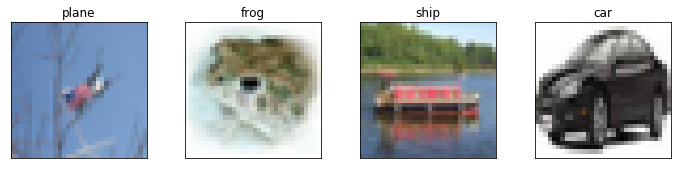

In [4]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    


net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


model_directory_path = './home/CIFAR-10 Classifier Using CNN in PyTorch/model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'
start_time = time.time()
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):
        
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i%2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                
        print('Finished Training.')
        torch.save(net.state_dict(), model_path)
        print('Saved model parameters to disk.')
        print(f"{(time.time() - start_time)/60} minutes")

Loaded model parameters from disk.


tensor([[-0.5427, -2.0790,  0.6975,  1.5593, -0.7127,  0.9927,  0.4919, -0.4547,
          0.1958, -0.3240],
        [ 3.1395,  4.3670, -1.9865, -2.3151, -2.6830, -3.1614, -2.5180, -2.4417,
          5.6213,  3.6211],
        [ 2.2868,  1.6404, -0.0400, -0.9356, -1.7692, -1.6672, -1.5851, -1.4742,
          3.3199,  1.6493],
        [ 2.8588,  1.4900, -0.1589, -1.3545, -0.6258, -2.1764, -1.9176, -1.3436,
          3.4129,  1.0465]], grad_fn=<AddmmBackward>)

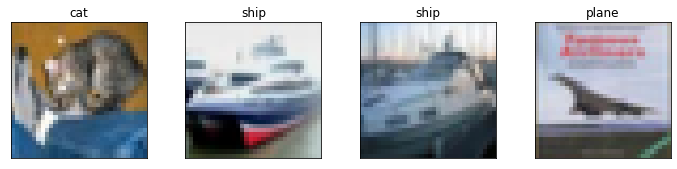

In [6]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    
outputs = net(images)
outputs

In [7]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)

tensor([[3.9088e-02, 8.4105e-03, 1.3509e-01, 3.1982e-01, 3.2976e-02, 1.8149e-01,
         1.0999e-01, 4.2684e-02, 8.1804e-02, 4.8644e-02],
        [5.5506e-02, 1.8943e-01, 3.2973e-04, 2.3738e-04, 1.6431e-04, 1.0184e-04,
         1.9379e-04, 2.0915e-04, 6.6398e-01, 8.9850e-02],
        [1.9683e-01, 1.0313e-01, 1.9212e-02, 7.8460e-03, 3.4090e-03, 3.7748e-03,
         4.0978e-03, 4.5783e-03, 5.5308e-01, 1.0405e-01],
        [3.0467e-01, 7.7514e-02, 1.4903e-02, 4.5083e-03, 9.3431e-03, 1.9818e-03,
         2.5673e-03, 4.5578e-03, 5.3021e-01, 4.9744e-02]],
       grad_fn=<SoftmaxBackward>)


In [8]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.3198
ship - 0.6640
ship - 0.5531
ship - 0.5302


In [9]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 50.56%


In [10]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 40.9
car        - 60.8
bird       - 40.7
cat        - 34.3
deer       - 23.3
dog        - 47.0
frog       - 60.6
horse      - 67.5
ship       - 70.7
truck      - 59.8


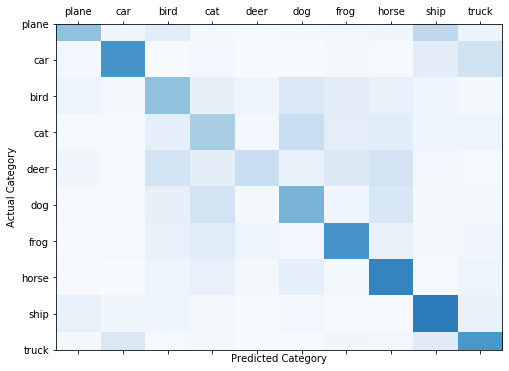

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [12]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           409       37        109       23        13        21        26        35        266       61        
                0.409     0.037     0.109     0.023     0.013     0.021     0.026     0.035     0.266     0.061     
car             28        608       6         24        6         4         16        13        103       192       
                0.028     0.608     0.006     0.024     0.006     0.004     0.016     0.013     0.103     0.192     
bird            47        17        407       85        50        145       111       73        42        23        
                0.047     0.017     0.407     0.085     0.05      0.145     0.111     0.073     0.042     0.023     
cat             13        7         90        343       24        232       98        107       36        50        
                0.013     0.007     0.09      0.343     0.024   

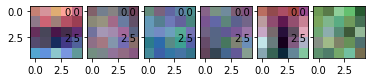

In [13]:
'''
Part 2
'''


def plot_kernels(tensor, num_cols=6):
    num_rows = 1
    fig = plt.figure(figsize=(num_cols, num_rows))
    i = 0
    for t in tensor:
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)
        pilTrans = transforms.ToPILImage()
        pilImg = pilTrans(t)
        ax1.imshow(pilImg, interpolation='none')
        i += 1
    
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.show()
    
    
    
kernels = net.conv1.weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels/kernels.max()
plot_kernels(kernels)

In [14]:
import torch.nn as nn

NUM_CLASSES = 10


class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x
    
    
net = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(1):

    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')
    print(f"{(time.time() - start_time)/60} minutes")
    
    
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

[1,  2000] loss: 2.303
[1,  4000] loss: 2.287
[1,  6000] loss: 2.072
[1,  8000] loss: 1.898
[1, 10000] loss: 1.769
[1, 12000] loss: 1.715
Finished Training.
Saved model parameters to disk.
45.055308151245114 minutes
Category   - Accuracy
plane      - 40.9
car        - 60.8
bird       - 40.7
cat        - 34.3
deer       - 23.3
dog        - 47.0
frog       - 60.6
horse      - 67.5
ship       - 70.7
truck      - 59.8


In [16]:
class BinaryNet(nn.Module):
    def __init__(self):
        super(BinaryNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
net = BinaryNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

trainset = torchvision.datasets.CIFAR10(root='./home/CIFAR-10 Classifier Using CNN in PyTorch2/data/',
                                       train=True,
                                       download=True,
                                       transform=transform)


testset = torchvision.datasets.CIFAR10(root='./home/CIFAR-10 Classifier Using CNN in PyTorch2/data',
                                      train=False,
                                      download=True,
                                      transform=transform)


for target in range(len(trainset.targets)):
    if trainset.targets[target] != 0:
        trainset.targets[target] = 1

for target in range(len(testset.targets)):
    if testset.targets[target] != 0:
        testset.targets[target] = 1
        
        
trainloader = torch.utils.data.DataLoader(trainset,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,shuffle=False)


for epoch in range(2):
        
    running_loss = 0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')
    print(f"{(time.time() - start_time)/60} minutes")

0it [00:00, ?it/s]

100%|█████████▉| 170270720/170498071 [00:22<00:00, 4137766.54it/s]

Extracting ./home/CIFAR-10 Classifier Using CNN in PyTorch2/data/cifar-10-python.tar.gz to ./home/CIFAR-10 Classifier Using CNN in PyTorch2/data/
Files already downloaded and verified
[1,  2000] loss: 0.291
[1,  4000] loss: 0.285


170500096it [00:40, 4137766.54it/s]                               

[1,  6000] loss: 0.281
[1,  8000] loss: 0.255
[1, 10000] loss: 0.261
[1, 12000] loss: 0.248
[1, 14000] loss: 0.262
[1, 16000] loss: 0.257
[1, 18000] loss: 0.235
[1, 20000] loss: 0.253
[1, 22000] loss: 0.214
[1, 24000] loss: 0.252
[1, 26000] loss: 0.241
[1, 28000] loss: 0.238
[1, 30000] loss: 0.233
[1, 32000] loss: 0.235
[1, 34000] loss: 0.252
[1, 36000] loss: 0.200
[1, 38000] loss: 0.205
[1, 40000] loss: 0.233
[1, 42000] loss: 0.214
[1, 44000] loss: 0.220
[1, 46000] loss: 0.207
[1, 48000] loss: 0.217
[1, 50000] loss: 0.215
Finished Training.
Saved model parameters to disk.
50.43070826530457 minutes
[2,  2000] loss: 0.197
[2,  4000] loss: 0.198
[2,  6000] loss: 0.209
[2,  8000] loss: 0.197
[2, 10000] loss: 0.204
[2, 12000] loss: 0.203
[2, 14000] loss: 0.188
[2, 16000] loss: 0.167
[2, 18000] loss: 0.213
[2, 20000] loss: 0.206
[2, 22000] loss: 0.175
[2, 24000] loss: 0.203
[2, 26000] loss: 0.206
[2, 28000] loss: 0.207
[2, 30000] loss: 0.194
[2, 32000] loss: 0.192
[2, 34000] loss: 0.213
[2,

In [20]:
sm = nn.Softmax(dim=1)
probs, index = torch.max(sm(net(images)), dim=1)

total_correct = 0
total_images = 0

predictions = []
correct_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct_labels.extend(labels.numpy().tolist())
        predictions.extend(predicted.numpy().tolist())
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

print("AUC Score: " + str(roc_auc_score(correct_labels, predictions)))
print(predictions[:10])

AUC Score: 0.6548888888888889
[1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
